In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *

# Generate Music with Pretrained Model

### Load Pretrained

In [4]:
# Config
config = default_config()

# Location of your midi files
midi_path =  Path('data/midi/examples')

# Location of saved datset
data_path = Path('data/numpy')
data_save_name = 'musicitem_data_save.pkl'

In [5]:
# Data
data = load_data(data_path, data_save_name)
vocab = data.vocab

In [6]:
# Pretrained Model
# Download pretrained model if you haven't already
pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained'
pretrained_path = untar_data(pretrained_url, dest=data_path)
load_path = pretrained_path/'MusicTransformer.pth'; load_path

PosixPath('data/numpy/pretrained/MusicTransformer.pth')

In [7]:
# Learner
learn = music_model_learner(data, config=config.copy(), pretrained_path=load_path)
# learn.to_fp16();

## Prediction

#### Choose existing midi file as a starting point

In [8]:
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files[:4]

[PosixPath('data/midi/examples/Levels - Avicii - Verse.mid'),
 PosixPath('data/midi/examples/Colors Of The Wind - Disney - Chorus.mid'),
 PosixPath('data/midi/examples/Where Is The Love - Black Eyed Peas - Chorus.mid'),
 PosixPath('data/midi/examples/La Bamba - Ritchie Valen - Chorus.mid')]

In [9]:
idx = 4
f = midi_files[idx]; f

PosixPath('data/midi/examples/I Want You Back - Jackson 5 - Intro.mid')

#### NextWord/Autocomplete

Trim the song to only a few notes. Model will use these notes a seed and continue the idea

In [10]:
cutoff_beat = 10

item = MusicItem.from_file(f, data.vocab)
seed_item = item.trim_to_beat(cutoff_beat)

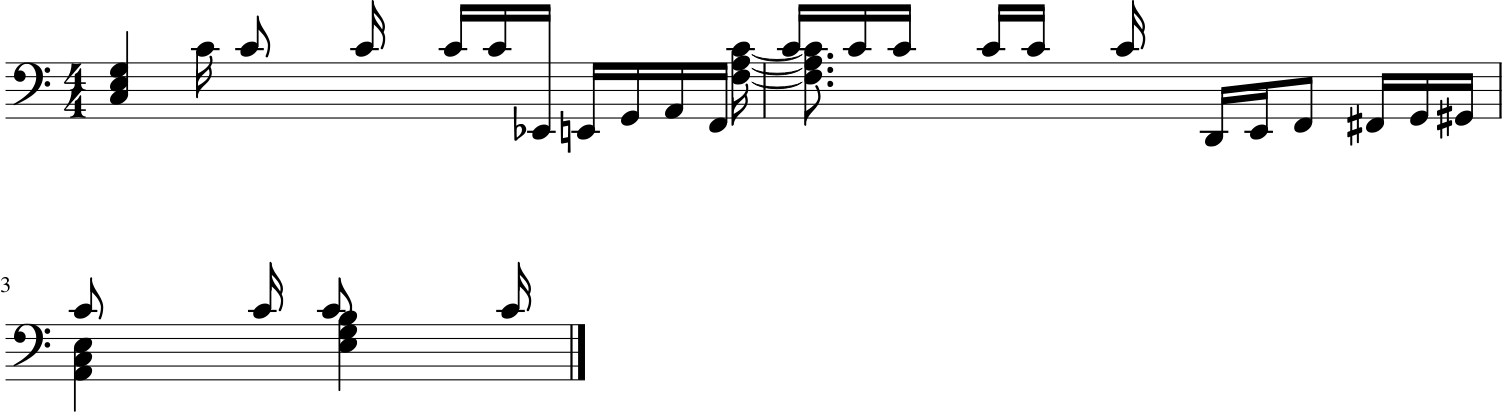

In [11]:
seed_item.show()

In [12]:
seed_item.play()

#### Use seed to predict next sequence

In [13]:
pred, full = learn.predict(seed_item, n_words=400, temperatures=(1.1,0.4), min_bars=12, top_k=24, top_p=0.7)

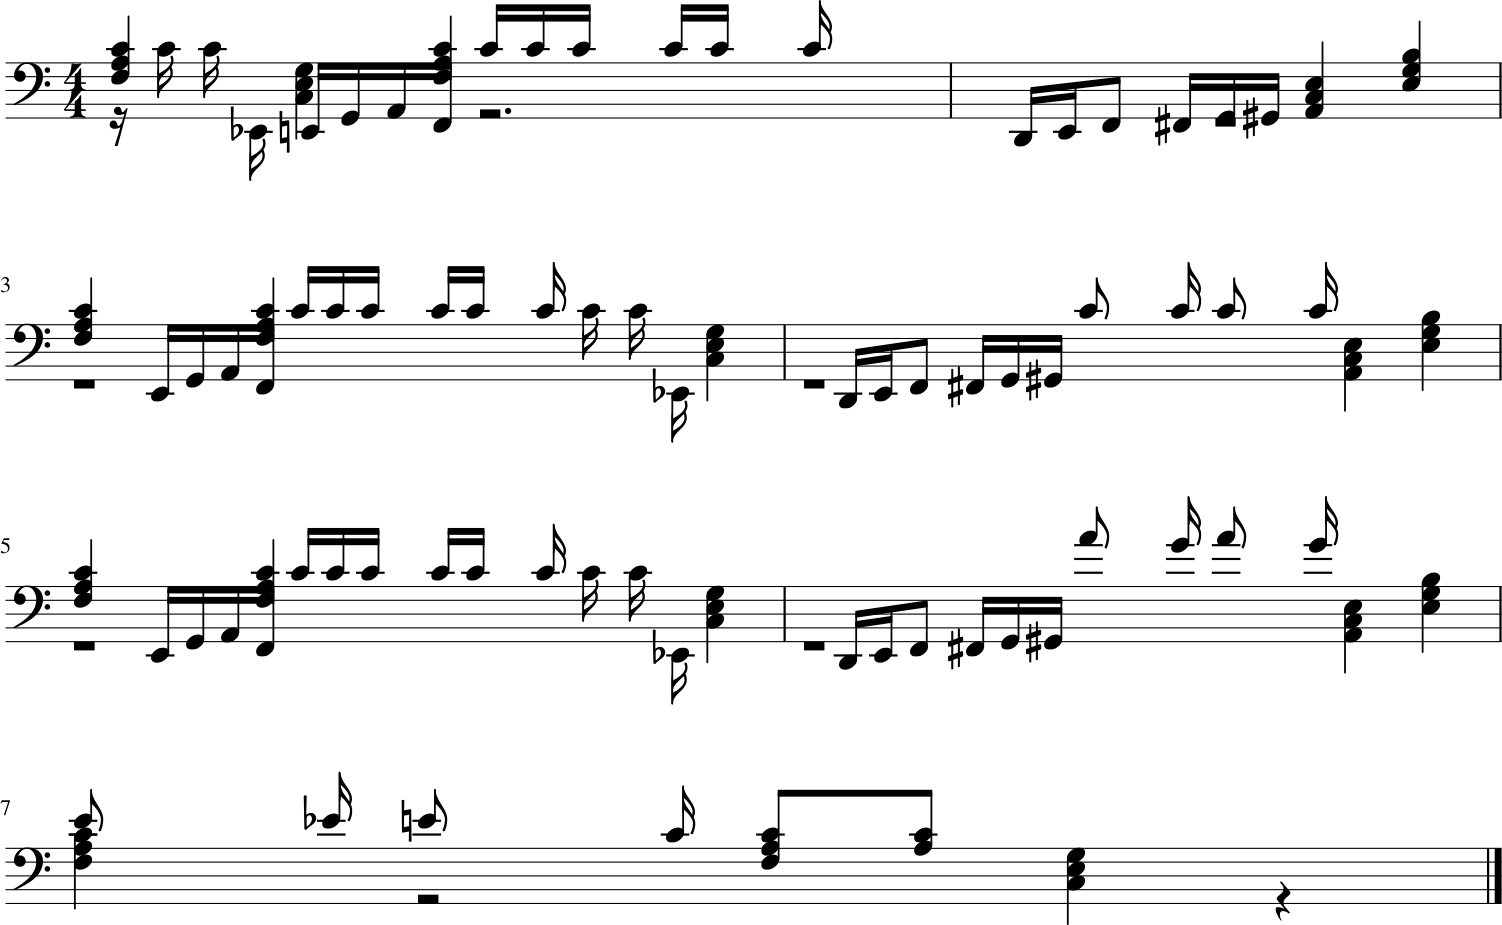

In [14]:
pred.show()

In [15]:
pred.play()

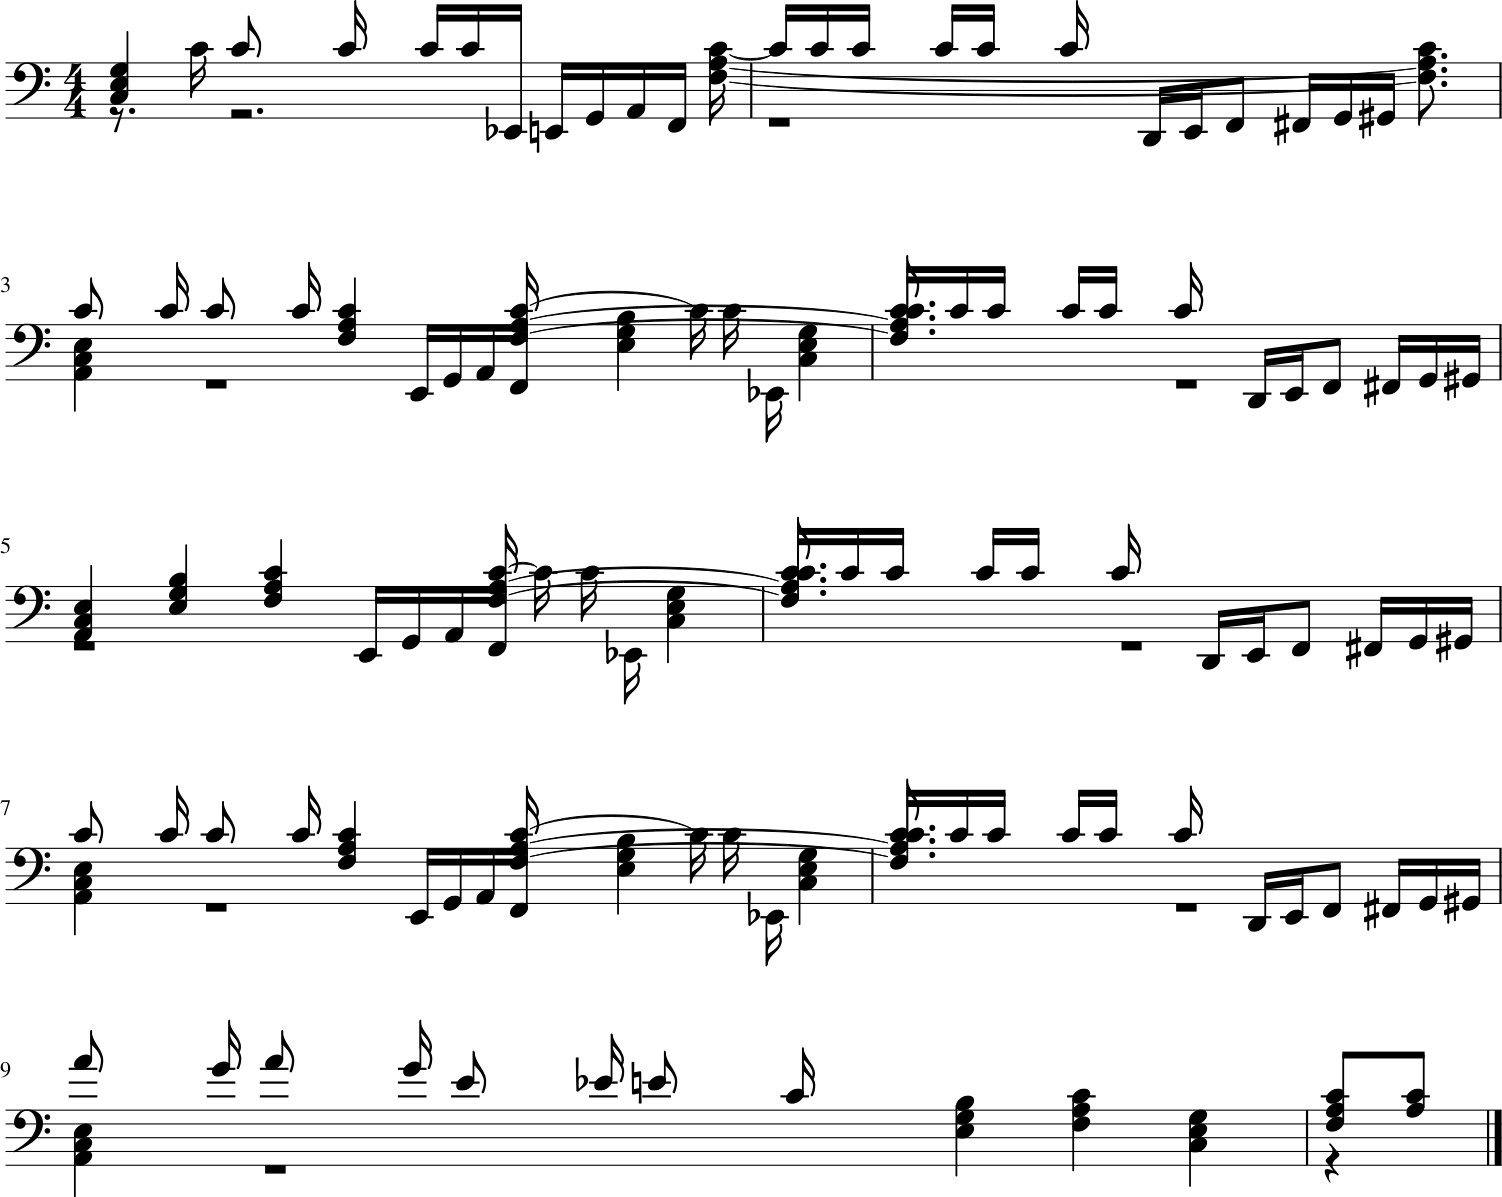

In [16]:
full_song = seed_item.append(pred); full_song.show()

In [17]:
full_song.play()

#### Add More Randomness to prediction

In [18]:
note_temp = 1.4 # Determines amount of variation in note pitches
dur_temp = 0.8 # Amount of randomness in rhythm
top_k = 30
pred, full = learn.predict(seed_item, n_words=400, temperatures=(note_temp, dur_temp), min_bars=12, top_k=top_k, top_p=0.7)

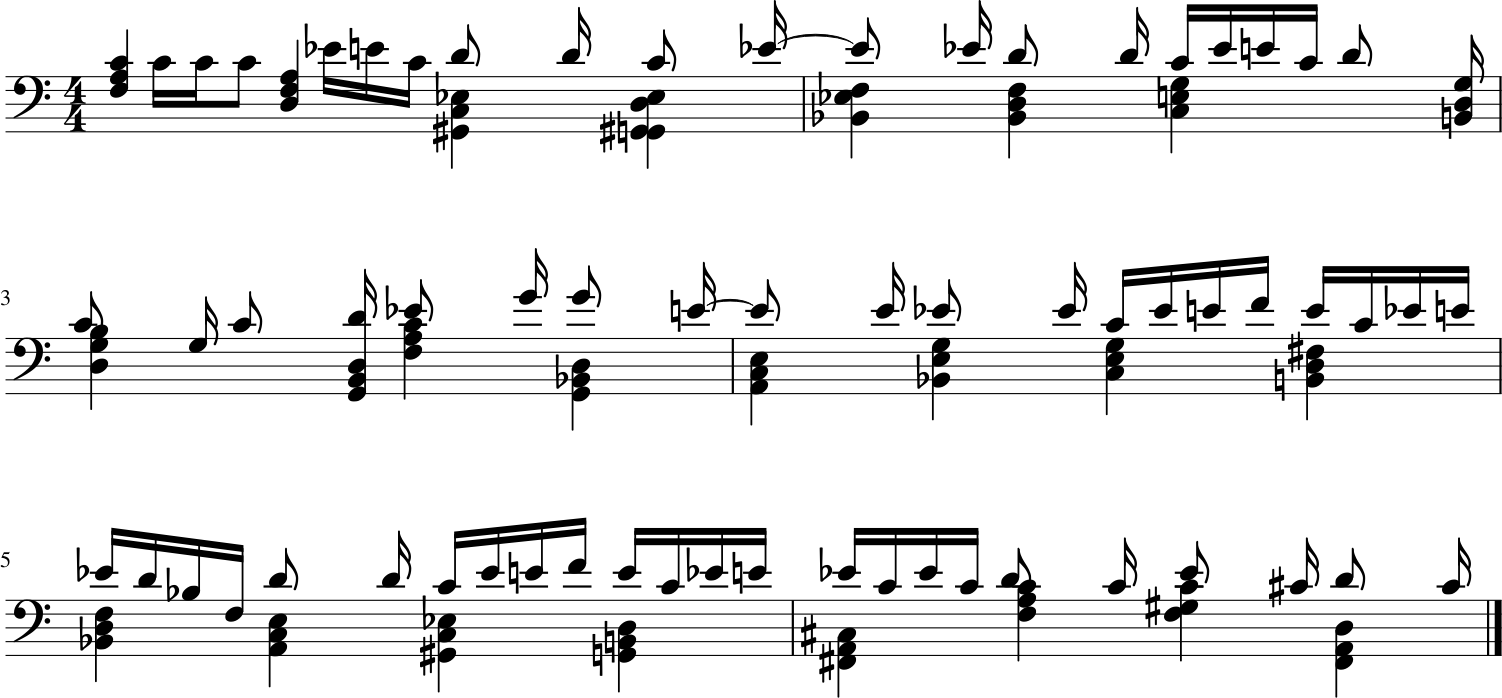

In [19]:
pred.show()

### Pop Music Theory

According to hooktheory, the most popular chord progression is I-V-vi-IV  
https://www.hooktheory.com/theorytab/common-chord-progressions

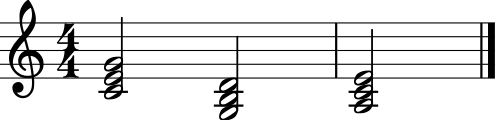

In [171]:
# Let's create a partial progression I-V-vi
p = music21.stream.Part()
p.append(music21.chord.Chord('C4 E4 G4', type='half')) # I
p.append(music21.chord.Chord('G3 B3 D4', type='half')) # V
p.append(music21.chord.Chord('A3 C4 E4', type='half')) # vi
s = music21.stream.Score([p])
chord_item = MusicItem.from_stream(s, vocab)
chord_item.show()

In [168]:
temperaturs = (0.5,0.5) # Let's lower the note randomness for this test
pred, full = learn.predict(chord_item, n_words=10, temperatures=(0.5,0.5))
full.show()

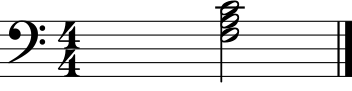

In [169]:
# Predicted chords - IV
pred.show()

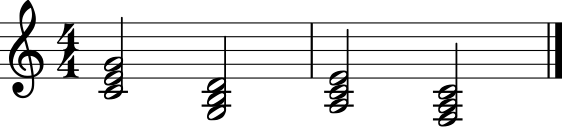

In [170]:
# Full sequence
chord_item.append(pred).show()

Looks like it predicted the most popular progression!

#### Predict without a starting sequence

In [20]:
empty_item = MusicItem.empty(vocab)

In [21]:
pred, full = learn.predict(empty_item, n_words=200)

Predicted BOS token. Returning prediction...


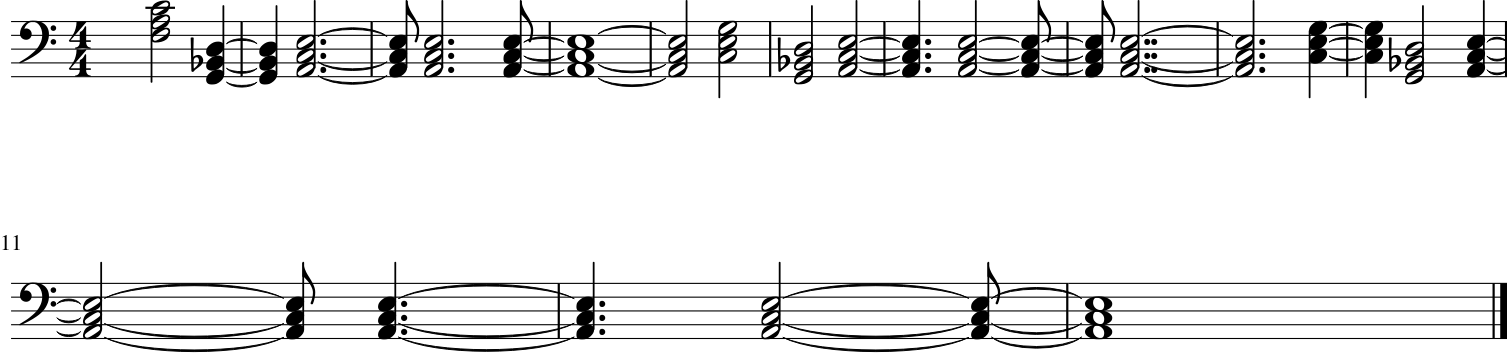

In [22]:
pred.show()